# Stochastic Simulation - Coursework 2023

This assignment has two parts and graded over **100 marks**. Some general remarks:

- The assignment is due on **11 December 2023, 1PM GMT**, to be submitted via Blackboard (see the instructions on the course website).
- You should use this .ipynb file as a skeleton and you should submit a PDF report. Prepare the IPython notebook and export it as a PDF. If you can't export your notebook as PDF, then you can export it as HTML and then use the "Print" feature in browser (Chrome: File -> Print) and choose "Save as PDF". 
- Your PDF should be no longer than 20 pages. But please be concise.
- You can reuse the code from the course material but note that this coursework also requires novel implementations. Try to personalise your code in order to avoid having problems with plagiarism checks. You can use Python's functions for sampling random variables of all distributions of your choice.
- **Please comment your code properly.**

Let us start our code.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

rng = np.random.default_rng(36) # You can change this.


## Q1: Model Selection via Perfect Monte Carlo (40 marks)

Consider the following probabilistic model
\begin{align*}
    p(x) &= \mathcal{N}(x; 5, 0.01), \\
    p(y_i|x) &= \mathcal{N}(y_i; \theta x, 0.05),
\end{align*}
for $i = 1, \ldots, T$ where $y_i$ are conditionally independent given $x$. You are given a dataset (see it on Blackboard) denoted here as $y_{1:T}$ for $T = 100$. As defined in the course, we can find the marginal likelihood as
\begin{align*}
p_\theta(y_{1:T}) = \int p_\theta(y_{1:T}|x) p(x) \mathrm{d} x,
\end{align*}
where we have left $\theta$-dependence in the notation to emphasise that the marginal likelihood is a function of $\theta$.

Given the samples from prior $p(x)$, we can identify our test function above as $\varphi(x) = p_\theta(y_{1:T}|x)$.

**(i)** The first step is to write a log-likelihood function of $y_{1:T}$, i.e., $p_\theta(y_{1:T} | x)$. Note that, this is the joint likelihood of conditionally i.i.d. observations $y_i$ given $x$. This function should take input the data set vector `y` as loaded from `y_perfect_mc.txt` below, $\theta$ (scalar), and $x$ (scalar), and `sig` (likelihood variance which is given as 0.05 in the question but leave it as a variable) values to evaluate the log-likelihood. Note that log-likelihood will be a **sum** in this case, over individual log-likelihoods. **<span style="color:blue">(10 marks)</span>**

In [2]:
# put the dataset in the same folder as this notebook
# the following line loads y_perfect_mc.txt
y = np.loadtxt('y_perfect_mc.txt')
y = np.array(y, dtype=np.float64)

# fill in your function below.

def log_likelihood(y, x, theta, sig): # fill in the arguments
    # fill in the function
    mu = theta * x
    n = len(y)
    l = - (n/2) * np.log(2*np.pi) - (n/2) * np.log(sig) - (1/(2*sig)) * np.sum(np.square(y - mu))
    return l

# uncomment and evaluate your likelihood (do not remove)
print(log_likelihood(y, 1, 1, 1))
print(log_likelihood(y, 1, 1, 0.1))
print(log_likelihood(y, -1, 2, 0.5))

-9898.905478066723
-98046.88084613332
-28974.21408410411


**(ii)** Write a logsumexp function. Let $\mathbf{v}$ be a vector of log-quantities and assume we need to compute $\log \sum_{i=1}^N \exp(v_i)$ where $\mathbf{v} = (v_1, \ldots, v_N)$. This function is given as
\begin{align*}
\log \sum_{i=1}^N \exp(v_i) = \log \sum_{i=1}^N \exp(v_i - v_{\max}) + v_{\max},
\end{align*}
where $v_{\max} = \max_{i = 1,\ldots,N} v_i$. Implement this as a function which takes a vector of log-values and returns the log of the sum of exponentials of the input values. **<span style="color:blue">(10 marks)</span>**

In [3]:
def logsumexp(v):
    # v is a vector
    v_max = np.max(v)
    return v_max + np.log(np.sum(np.exp(v - v_max)))

#  uncomment and evaluate your logsumexp function (do not remove)
print(logsumexp(np.array([1, 2, 3])))
print(logsumexp(np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])))
print(logsumexp(np.array([5, 6, 9, 12])))

3.4076059644443806
10.45862974442671
12.051811977232925


**(iii)** Now we are at the stage of implementing the log marginal likelihood estimator. Inspect your estimator as described in Part (i). Its particular form is not implementable without using the trick you have coded in Part (iii). Now, implement a function that returns the **log** of the MC estimator you derived in Part (i). This function will take in

- `y` dataset vector
- $\theta$ parameter (scalar)
- `x_samples` (`np.array` vector) which are $N$ Monte Carlo samples.
- a variance (scalar) variable `sig` for the joint log likelihood $p_\theta(y_{1:T} | x)$ that will be used in `log_likelihood` function (we will set this to 0.05 as given in the question).

**Hint:** Notice that the log of the MC estimator of the marginal likelihood takes the form
\begin{align*}
\log \frac{1}{N} \sum_{i=1}^N p_\theta(y_{1:T} | x^{(i)}),
\end{align*}
as given in the question. You have to use $p_\theta(y_{1:T} | x^{(i)}) = \exp(\log p_\theta(y_{1:T} | x^{(i)}))$ to get a `logsumexp` structure, i.e., $\log$ and $\text{sum}$ (over particles) and $\exp$ of $\log p_\theta(y_{1:T} | x^{(i)})$ where $i = 1, \ldots, N$ and $x^{(i)}$ are the $N$ Monte Carlo samples (do **not** forget $1/N$ term too). Therefore, now use the function of Part (i) to compute $\log p_\theta(y_{1:T} | x^{(i)})$ for every $i = 1,\ldots, N$ and Part (ii) `logsumexp` these values to compute the estimate of log marginal likelihood. **<span style="color:blue">(10 marks)</span>**

In [4]:
def log_marginal_likelihood(y, theta, x_samples, sig): # fill in the arguments
    # fill in the function
    N = len(x_samples)
    log_p = []
    for xi in x_samples:
        log_p.append(log_likelihood(y, xi, theta, sig))
    return -np.log(N) + logsumexp(log_p)

# uncomment and evaluate your marginal likelihood (do not remove)

print(log_marginal_likelihood(y, 1, np.array([-1, 1]), 1))
print(log_marginal_likelihood(y, 1, np.array([-1, 1]), 0.1))
print(log_marginal_likelihood(y, 2, np.array([-1, 1]), 0.5))

# note that the above test code takes 2 dimensional array instead of N particles for simplicity

-9899.598625247283
-98047.57399331388
-16970.96811085916


**(iv)** We will now try to find the most likely $\theta$. For this part, you will run your `log_marginal_likelihood` function for a range of $\theta$ values. Note that, for every $\theta$ value, you need to sample $N$ new samples from the prior (do not reuse the same samples). Compute your estimator of the $\log \hat{\pi}_{\text{MC}}^N \approx \log p_\theta(y_{1:T})$ for $\theta$-range given below. Plot the log marginal likelihood estimator as a function of $\theta$. **<span style="color:blue">(5 marks)</span>**

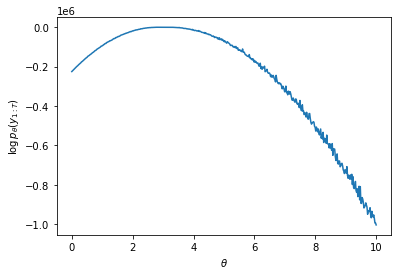

In [5]:
sig = 0.05
sig_prior = 0.01
mu_prior = 5.0

N = 1000

theta_range = np.linspace(0, 10, 500)
log_ml_list = np.array([]) # you can use np.append to add elements to this array

# fill in your code here
for theta in theta_range:
    log_ml_list = np.append(log_ml_list,log_marginal_likelihood(y, theta, np.random.normal(mu_prior,np.sqrt(sig_prior),N), sig))

# uncomment and plot your results (do not remove)
plt.plot(theta_range, log_ml_list)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\log p_\theta(y_{1:T})$')
plt.show()

**(v)** Now you have `log_ml_list` variable that corresponds to marginal likelihood values in `theta_range`. Find the $\theta$ value that gives the maximum value in this list and provide your final estimate of most likely $\theta$. **<span style="color:blue">(5 marks)</span>**

In [6]:
# You code goes here
theta_est = theta_range[np.argmax(log_ml_list)]
# print your theta estimate, e.g.:
print(f"The maximising value of theta is {theta_est}")

The maximising value of theta is 3.006012024048096


## Q2: Posterior sampling (35 marks)

In this question, we will perform posterior sampling for the following model
\begin{align*}
    p(x) &\propto \exp(-x_1^2/10 - x_2^2/10 - 2 (x_2 - x_1^2)^2), \\
    p(y | x) &= \mathcal{N}(y; H x, 0.1)
\end{align*}
where $H = [0, 1]$. In this exercise, we assume that we have observed $y = 2$ and would like to implement a few sampling methods.

Before starting this exercise, please try to understand how the posterior density should look like. The discussion we had during the lecture about Exercise 6.2 (see Panopto if you have not attended) should help you here to understand the posterior density. Note though quantities and various details are **different** here. You should have a good idea about the posterior density before starting this exercise to be able to set the hyperparameters such as the chain-length, proposal noise, and the step-size.

In [7]:
y = np.array([2.0])
sig_lik = 0.1
H = np.array([0, 1])

**(i)** In what follows, you will have to code the log-prior and log-likelihood functions. Do **not** use any library, code the log densities directly. **<span style="color:blue">(5 marks)</span>**

In [8]:
def prior(x): # code banana density for visualisation purposes
    # fill in the function
    x1 = x[0]
    x2 = x[1]
    return np.exp(-x1**2/10 - x2**2/10 - 2*(x2 - x1**2)**2)

def log_prior(x): # fill in the arguments
    # fill in the function
    x1 = x[0]
    x2 = x[1]
    return -x1**2/10 - x2**2/10 - 2*(x2 - x1**2)**2

def log_likelihood(y, x, sig_lik): # fill in the arguments
    # fill in the function
    return (-(y - H @ x) ** 2/(2 * sig_lik) - np.log(np.sqrt(2 * np.pi * sig_lik)))

# uncomment below and evaluate your prior and likelihood (do not remove)
print(log_prior([0, 1]))
print(log_likelihood(y, np.array([0, 1]), sig_lik))

-2.1
[-4.76764599]


**(ii)** Next, implement **the random walk Metropolis algorithm (RWMH)** for this target. Set an appropriate chain length, proposal variance, and `burnin` value. Plot a scatter-plot with your samples (see the visualisation function below). Use log-densities only. **<span style="color:blue">(10 marks)</span>**

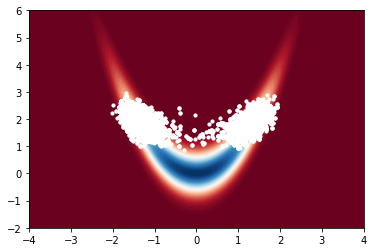

In [28]:
# fill in your code here
N = 10000
x = np.zeros((N,2))

# initial values
x[0, :] = np.array([0, 0])

# parameters
burnin = int(N * 0.2)
sig_proposal = 0.5

for n in range(1, N):
    # random walk
    x_s = x[n-1, :] + sig_proposal * rng.normal(0,1,2) # standard normal noise

    # metropolis
    u = rng.uniform(0, 1)

    # target as given on pg 105
    if np.log(u) < log_prior(x_s) + log_likelihood(y, x_s, sig_lik) - log_prior(x[n-1, :]) - log_likelihood(y, x[n-1, :], sig_lik):
        x[n, :] = x_s
    else:
        x[n, :] = x[n-1, :]

# uncomment and plot your results (do not remove)
x_bb = np.linspace(-4, 4, 100)
y_bb = np.linspace(-2, 6, 100)
X_bb , Y_bb = np.meshgrid(x_bb , y_bb)
Z_bb = np.zeros((100 , 100))
for i in range(100):
    for j in range(100):
        Z_bb[i, j] = prior([X_bb[i, j], Y_bb[i, j]])
plt.contourf(X_bb , Y_bb , Z_bb , 100 , cmap='RdBu')
plt.scatter(x[burnin:, 0], x[burnin:, 1], s=10 , c='white')
plt.show()

# Note that above x vector (your samples) is assumed to be (N, 2).
# It does not have to be this way (You can change the name of the variable x too).
# i.e., If your x vector is (2, N), then use
# plt.scatter(x[0, :], x[1, :], s=10 , c='white')
# instead of
# plt.scatter(x[:, 0], x[:, 1], s=10 , c='white')
# in the above code.

**(iii)** Now implement **Metropolis-adjusted Langevin algorithm**. For this, you will need to code the gradient of the density and use it in the proposal as described in the lecture notes. Set an appropriate chain length, step-size, and `burnin` value. Plot a scatter-plot with your samples (see the visualisation function below). Use log-densities only. **<span style="color:blue">(10 marks)</span>**

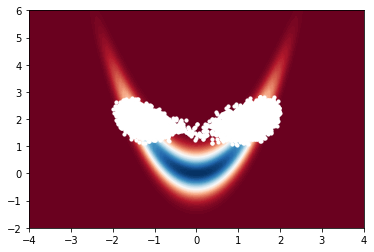

In [29]:
def grad_log_prior(x): # fill in the arguments
    # fill in the function
    x1 = x[0]
    x2 = x[1]
    return np.array([(-x1/5 + 8*x1*(x2 - x1**2)), (-x2/5 - 4*(x2 - x1**2))])

def grad_log_likelihood(y, x, sig_lik): # fill in the arguments
    # fill in the function
    return np.array([0, ((y - x[1])/sig_lik)])

def log_MALA_kernel(x_s, x, gamma): # fill in the arguments
    # fill in the function
    return - (1/(4 * gamma)) * np.linalg.norm(x_s - x - gamma * grad_log_prior(x)) ** 2

gamma = 0.02
N = 50000
burnin = 200

# initisl values are zeros
x = np.zeros((N, 2))

sigma = np.sqrt(2 * gamma)

for n in range(1, N):
    u = rng.uniform(0,1)
    x_s_l = x[n-1, :] + gamma * (grad_log_prior(x[n-1, :]) + grad_log_likelihood(y[0], x[n-1, :], sig_lik)) + sigma * rng.normal(0, 1, 2)
    u = rng.uniform(0, 1)
    if np.log(u) < log_prior(x_s_l) + log_likelihood(y[0], x_s_l, sig_lik) - log_prior(x[n-1, :]) - log_likelihood(y[0], x[n-1, :], sig_lik) + log_MALA_kernel(x[n-1, :], x_s_l, gamma) -log_MALA_kernel(x_s_l ,x[n-1, :], gamma):
        x[n, :] = x_s_l
    else:
        x[n, :] = x[n-1, :]

# uncomment and plot your results (do not remove)
x_bb = np.linspace(-4, 4, 100)
y_bb = np.linspace(-2, 6, 100)
X_bb , Y_bb = np.meshgrid(x_bb , y_bb)
Z_bb = np.zeros((100 , 100))
for i in range(100):
    for j in range(100):
        Z_bb[i, j] = prior([X_bb[i, j], Y_bb[i, j]])
plt.contourf(X_bb , Y_bb , Z_bb , 100 , cmap='RdBu')
plt.scatter(x[burnin:, 0], x[burnin:, 1], s=10 , c='white')
plt.show()

# Note that above x vector (your samples) is assumed to be (N, 2).
# It does not have to be this way (You can change the name of the variable x too).
# i.e., If your x vector is (2, N), then use
# plt.scatter(x[0, :], x[1, :], s=10 , c='white')
# instead of
# plt.scatter(x[:, 0], x[:, 1], s=10 , c='white')
# in the above code.

**(iv)** Next, implement **unadjusted Langevin algorithm**. For this, you will need to code the gradient of the density and use it in the proposal as described in the lecture notes. Set an appropriate chain length, step-size, and `burnin` value. Plot a scatter-plot with your samples (see the visualisation function below). Use log-densities only. **<span style="color:blue">(10 marks)</span>**

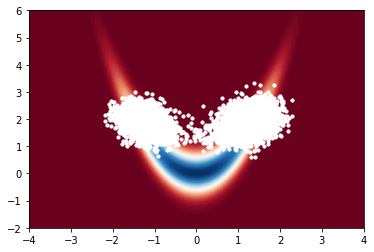

In [38]:
# fill in your code here

# parameters
gam = 0.03
sigma = np.sqrt(2 * gam)
N = 10000
burnin = 200

# initial values are zeros
x = np.zeros((N, 2))

for n in range(1, N):
    x[n, :] = x[n-1, :] + gam * (grad_log_prior(x[n-1, :]) + grad_log_likelihood(y[0], x[n-1, :], sig_lik)) + sigma * rng.normal(0, 1, 2)



# uncomment and plot your results (do not remove)
x_bb = np.linspace(-4, 4, 100)
y_bb = np.linspace(-2, 6, 100)
X_bb , Y_bb = np.meshgrid(x_bb , y_bb)
Z_bb = np.zeros((100 , 100))
for i in range(100):
    for j in range(100):
        Z_bb[i, j] = prior([X_bb[i, j], Y_bb[i, j]])
plt.contourf(X_bb , Y_bb , Z_bb , 100 , cmap='RdBu')
plt.scatter(x[burnin:, 0], x[burnin:, 1], s=10 , c='white')
plt.show()

# Note that above x vector (your samples) is assumed to be (N, 2).
# It does not have to be this way (You can change the name of the variable x too).
# i.e., If your x vector is (2, N), then use
# plt.scatter(x[0, :], x[1, :], s=10 , c='white')
# instead of
# plt.scatter(x[:, 0], x[:, 1], s=10 , c='white')
# in the above code.

## Q3: Gibbs sampling for 2D posterior (25 marks)

In this question, you will first derive a Gibbs sampler by deriving full conditionals. Then we will describe a method to estimate marginal likelihoods using Gibbs output (and you will be asked to implement the said method given the description).

Consider the following probabilistic model
\begin{align*}
p(x_1) &= \mathcal{N}(x_1; \mu_1, \sigma_1^2), \\
p(x_2) &= \mathcal{N}(x_2; \mu_2, \sigma_2^2), \\
p(y | x_1, x_2) &= \mathcal{N}(y; x_1 + x_2, \sigma_y^2),
\end{align*}
where $y$ is a scalar observation and $x_1, x_2$ are latent variables. This is a simple model where we observe a sum of two random variables and want to construct possible values of $x_1, x_2$ given the observation $y$.

**(i)** Derive the Gibbs sampler for this model, by deriving full conditionals $p(x_1 | x_2, y)$ and $p(x_2 | x_1, y)$ (You can use Example 3.2 but note that this case is different). **<span style="color:blue">(10 marks)</span>**

**Solution:** <span style="color:red">**Your answer here in LaTeX. If you prefer handwritten, please write here "Handwritten" and attach your pdf to the end and clearly number your answer Q3(i)**</span>

Beginnning with $p(x_1|y,x_2)$ using the Bayes Rule:
$$p(x_1|y,x_2)=\frac{p(y,x_1,x_2)}{p(y,x_2)}$$
$$p(x_1|y,x_2)=\frac{p(y|x_1,x_2)p(x_1,x_2)}{p(y,x_2)}$$
$$p(x_1|y,x_2)=\frac{p(y|x_1,x_2)p(x_1|x_2)p(x_2)}{p(y,x_2)}$$
$$p(x_1|y,x_2)=\frac{p(y|x_1,x_2)p(x_1|x_2)p(x_2)}{p(y|x_2)p(x_2)}$$
$$p(x_1|y,x_2)=\frac{p(y|x_1,x_2)p(x_1|x_2)}{p(y|x_2)}$$

Since $y$ is an observed value, we can consider $p(y|x_2)$ to be a constant, and we obtain:
$$p(x_1|y,x_2)\propto p(y|x_1,x_2)p(x_1|x_2)$$

Since both of the RHS distributions are known, we can use these to obtain the distribution of $p(x_1|y,x_2)$ up to some scaling constant:

\begin{align*}
p(x_1|y, x_2)&\propto \frac{1}{\sqrt{2\pi \sigma_y^2}} \exp \left(-\frac{(y-x_1-x_2)^2}{2\sigma_y^2} \right) \frac{1}{\sqrt{2\pi \sigma_1^2}} \exp \left(-\frac{(x_1-\mu_1)^2}{2\sigma_1^2} \right) \\
&\propto \frac{1}{2\pi\sqrt{ \sigma_y^2 \sigma_1^2}} \exp \left( - \frac{y^2 + x_1^2 + x_2^2 -2yx_1 -2yx_2 + 2x_1 x_2}{\sigma_y^2} - \frac{x_1^2 - 2x_1\mu_1 + \mu_1^2}{\sigma_1^2}   \right) \\
&\propto \frac{1}{\sqrt{2\pi \sigma_y^2 \sigma_1^2}} \exp \left( - \frac{y^2 + x_1^2 + x_2^2 -2yx_1 -2yx_2 + 2x_1 x_2}{2\sigma_y^2} - \frac{x_1^2 - 2x_1\mu_1 + \mu_1^2}{2\sigma_1^2}   \right) \\
&\propto \frac{1}{\sqrt{2\pi \sigma_y^2 \sigma_1^2}} \exp \left( -\frac{\sigma_1^2(y^2 + x_1^2 + x_2^2 -2yx_1 -2yx_2 + 2x_1 x_2) + \sigma_y^2 (x_1^2 - 2x_1\mu_1 + \mu_1^2)}{2\sigma_y^2 \sigma_1^2}  \right)
\end{align*}

Since we are working with a scaler multiple of the desired distribution, we can ignore any elements in the eponential which do not include an $x_1$:

\begin{align*}
p(x_1|y, x_2)&\propto \frac{1}{\sqrt{2\pi \sigma_y^2 \sigma_1^2}} \exp \left(- \frac{\sigma_1^2(x_1^2 - 2yx_1 + 2x_1 x_2) + \sigma_y^2 (x_1^2 - 2x_1\mu_1 )}{2\sigma_y^2 \sigma_1^2}  \right) \\
&\propto \frac{1}{\sqrt{2\pi \sigma_y^2 \sigma_1^2}} \exp \left( -\frac{(\sigma_1^2 + \sigma_y^2)x_1^2 + (2x_2 \sigma_1^2 -2y\sigma_1^2 - 2\mu \sigma_y^2)x_1}{2\sigma_y^2 \sigma_1^2}  \right) \\
&\propto \frac{1}{\sqrt{2\pi \sigma_y^2 \sigma_1^2}} \exp \left( -\frac{x_1^2 + \frac{(2x_2 \sigma_1^2 -2y\sigma_1^2 - 2\mu \sigma_y^2)}{{\sigma_1^2 + \sigma_y^2}}x_1}{2\frac{\sigma_y^2 \sigma_1^2}{\sigma_1^2 + \sigma_y^2}}  \right) \\
&\propto \frac{1}{\sqrt{2\pi \sigma_y^2 \sigma_1^2}} \exp \left( -\frac{x_1^2 + \frac{(2x_2 \sigma_1^2 -2y\sigma_1^2 - 2\mu \sigma_y^2)}{{\sigma_1^2 + \sigma_y^2}}x_1 + \left( \frac{x_2\sigma_1^2-y\sigma_1^2-2\mu\sigma_y^2}{\sigma_1^2 + \sigma_y^2}\right)^2}{2\frac{\sigma_y^2 \sigma_1^2}{\sigma_1^2 + \sigma_y^2}}  \right) \\
&\propto \frac{1}{\sqrt{2\pi \sigma_y^2 \sigma_1^2}} \exp \left( -\frac{\left( x- \frac{y \sigma_1^2 + \mu_1 \sigma_y^2 - x_2\sigma_1^2}{\sigma_1^2 + \sigma_y^2} \right)^2)}{2\frac{\sigma_y^2 \sigma_1^2}{\sigma_1^2 + \sigma_y^2}}  \right) \\
\end{align*}

So we conclude that the conditional of $x_1$ has the following distribution:

$$p(x_1|y,x_2) \sim N\left( \frac{y \sigma_1^2 + \mu_1 \sigma_y^2 - x_2\sigma_1^2}{\sigma_1^2 + \sigma_y^2} , \frac{\sigma_y^2 \sigma_1^2}{\sigma_1^2 + \sigma_y^2} \right)$$

Analagously:

$$p(x_2|y,x_1) \sim N\left( \frac{y \sigma_2^2 + \mu_2 \sigma_y^2 - x_1\sigma_2^2}{\sigma_2^2 + \sigma_y^2} , \frac{\sigma_y^2 \sigma_2^2}{\sigma_2^2 + \sigma_y^2} \right)$$

**(ii)** Let us set $y = 5$, $\mu_1 = 0$, $\mu_2 = 0$, $\sigma_1 = 0.1$, $\sigma_2 = 0.1$, and $\sigma_y = 0.01$.

Implement the Gibbs sampler you derived in Part (i). Set an appropriate chain length and `burnin` value. Plot a scatter plot of your samples (see the visualisation function below). Discuss the result: Why does the posterior look like this? **<span style="color:blue">(15 marks)</span>**

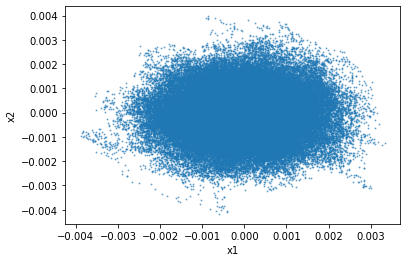

In [39]:
y = 5

mu1 = 0
mu2 = 0
sig1 = 0.1
sig2 = 0.1

sig_y = 0.01

N = 100000
burnin = 200

# def x1_conditional():
#     pass

x = np.zeros((N, 3))

for n in range(1, N):
    x[n, 0] = rng.normal((x[n-1,2]*sig1**2 + mu1*sig_y**2 - x[n-1,1]*sig1**2)/(sig1**2 + sig_y**2), (sig_y**2 * sig1**2)/(sig1**2 + sig_y**2))
    x[n, 1] = rng.normal((x[n-1,2]*sig2**2 + mu2*sig_y**2 - x[n,0]*sig2**2)/(sig2**2 + sig_y**2), (sig_y**2 * sig2**2)/(sig2**2 + sig_y**2))
    x[n, 2] = rng.normal((x[n,0] + x[n,1]), sig_y**2)

x1_chain = x[:, 0]
x2_chain = x[:, 1]
y_chain = x[:, 2]

# uncomment and plot your results (do not remove)
plt.scatter(x1_chain[burnin:], x2_chain[burnin:], s=1, alpha=0.5)
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

<span style="color:red">**Your discussion goes here. (in words).**</span> 

This diagram provides an insight into the joint distribution of $x_1$, $x_2$ and $y$. We observe that $x_1$, $x_2$ and $y$ have a multivarite normal joint distribution. As defined in the question, $x_1$ and $x_2$ are independent of each other, but not of $y$. 

We obtain a joint distribution of:
$$p(x_1,x_2,y)\sim N\left( \begin{bmatrix}
           \mu_{1} \\
           \mu_{2} \\
           x_1 + x_2 \\
         \end{bmatrix}   , 
         \begin{bmatrix}
           \sigma_{1}^2 & 0 & \rho_{x_1 y} \\
           0 & \sigma_{2}^2 & \rho_{x_2 y} \\
           \rho_{x_1 y} & \rho_{x_2 y} & \sigma_y^2 \\
         \end{bmatrix}
         \right)$$


In the case of $x_1$ and $x_2$ as shown in the plot, we have a mean and $(0,0)$, and a symmetrical distribution since $\sigma_1^2=\sigma_2^2=0.1$. 